In [1]:
import scanpy as sc
import pandas as pd
import scipy.io
import anndata
from scipy.sparse import csr_matrix
import os
import scanpy as sc
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import re

/home/liuxiaodongLab/jiangjing/miniconda3/envs/agent_new/lib/python3.10/site-packages/torch/cuda/__init__.py:56: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/liuxiaodongLab/jiangjing/miniconda3/envs/agent_new/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/liuxiaodongLab/jiangjing/miniconda3/envs/agent_new/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/liuxiaodongLab/jiangjing/miniconda3/envs/agent_new/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel fro

In [2]:
adata=sc.read_h5ad("/storage/liuxiaodongLab_tmp/jiangjing/20260127_hypoblast_100sample_anno/data/hypoblast_100_samples_human_aligned_only_counts.h5ad")

In [5]:
print(adata.obs['condition'].value_counts())

condition
H25        23117
H46        20865
H26        19166
H93        17543
H95        17259
           ...  
control     5406
H18         5324
H86         5010
H126        3850
H21         2710
Name: count, Length: 100, dtype: int64


In [6]:
adata = adata[adata.obs['condition'] != 'H163'].copy()

In [7]:
print(adata.obs['condition'].value_counts())

condition
H25        23117
H46        20865
H26        19166
H93        17543
H95        17259
           ...  
control     5406
H18         5324
H86         5010
H126        3850
H21         2710
Name: count, Length: 99, dtype: int64


In [8]:
import scanpy as sc
import numpy as np

def calculate_qc_metrics(adata):
    """
    计算质控指标：线粒体基因比例、核糖体基因比例等
    """
    print("计算质控指标...")
    
    # 确保有基因注释信息
    if 'gene_name' not in adata.var.columns and adata.var.index.name == 'gene_ids':
        adata.var.index = adata.var.index.astype(str)
    
    # 识别线粒体基因（根据不同物种调整）
    # 人类/小鼠：以mt-或MT-开头
    # 可以根据你的物种调整
    if adata.var.index.dtype == 'object':
        # 尝试不同格式的线粒体基因标识
        mt_patterns = ['^MT-', '^mt-', '_MT', '_mt', 'MT.', 'mt.']
        
        for pattern in mt_patterns:
            mt_genes = adata.var.index.str.contains(pattern, case=False, regex=True)
            if mt_genes.sum() > 0:
                print(f"找到 {mt_genes.sum()} 个线粒体基因 (使用模式: {pattern})")
                break
        else:
            # 如果没有找到，尝试基因名字段
            if 'gene_name' in adata.var.columns:
                for pattern in mt_patterns:
                    mt_genes = adata.var['gene_name'].str.contains(pattern, case=False, regex=True, na=False)
                    if mt_genes.sum() > 0:
                        print(f"找到 {mt_genes.sum()} 个线粒体基因 (使用模式: {pattern})")
                        break
                else:
                    mt_genes = np.zeros(adata.n_vars, dtype=bool)
                    print("警告: 未找到线粒体基因，请检查基因注释")
    else:
        mt_genes = np.zeros(adata.n_vars, dtype=bool)
    
    # 识别核糖体基因
    ribosomal_patterns = ['^RP[LS]', '^rp[ls]', 'Rps', 'Rpl']
    ribo_genes = np.zeros(adata.n_vars, dtype=bool)
    
    for pattern in ribosomal_patterns:
        if adata.var.index.dtype == 'object':
            ribo_genes = ribo_genes | adata.var.index.str.contains(pattern, case=False, regex=True)
        if 'gene_name' in adata.var.columns:
            ribo_genes = ribo_genes | adata.var['gene_name'].str.contains(pattern, case=False, regex=True, na=False)
    
    # 计算基本QC指标
    print("计算每个细胞的基因数和UMI数...")
    adata.var['mt'] = mt_genes
    adata.var['ribo'] = ribo_genes
    
    # 计算各种QC指标
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=['mt', 'ribo'], 
        percent_top=None, 
        log1p=False, 
        inplace=True
    )
    
    print(f"计算完成:")
    print(f"  - 总细胞数: {adata.n_obs}")
    print(f"  - 总基因数: {adata.n_vars}")
    print(f"  - 线粒体基因比例范围: {adata.obs['pct_counts_mt'].min():.2f}% - {adata.obs['pct_counts_mt'].max():.2f}%")
    print(f"  - 核糖体基因比例范围: {adata.obs['pct_counts_ribo'].min():.2f}% - {adata.obs['pct_counts_ribo'].max():.2f}%")
    print(f"  - 每个细胞检测到的基因数范围: {adata.obs['n_genes_by_counts'].min()} - {adata.obs['n_genes_by_counts'].max()}")
    print(f"  - 每个细胞的UMI总数范围: {adata.obs['total_counts'].min()} - {adata.obs['total_counts'].max()}")
    
    return adata

def preprocess_and_qc_analysis(adata_combined, filter_params):
    """
    对合并的adata进行质控和分析
    """
    
    print("="*60)
    print("开始质控分析流程")
    print("="*60)
    
    # 步骤1: 计算质控指标
    initial_shape = adata_combined.shape
    print(f"初始数据形状: {initial_shape}")
    
    adata_combined = calculate_qc_metrics(adata_combined)
    
    # 步骤2: 保存原始counts
    print("\n保存原始counts数据...")
    adata_combined.layers["counts"] = adata_combined.X.copy()
    
    # 步骤3: 质控过滤
    print("\n进行质控过滤...")
    print(f"使用过滤参数: {filter_params}")
    
    initial_cells = adata_combined.n_obs
    
    # 创建过滤掩码
    filter_mask = (
        (adata_combined.obs['n_genes_by_counts'] > filter_params['min_genes']) & 
        (adata_combined.obs['n_genes_by_counts'] < filter_params['max_genes']) & 
        (adata_combined.obs['total_counts'] > filter_params['min_counts']) & 
        (adata_combined.obs['total_counts'] < filter_params['max_counts']) & 
        (adata_combined.obs['pct_counts_mt'] < filter_params['max_mt'])
    )
    
    # 如果是合并的数据，可能有不同样本，可以分别查看
    if 'condition' in adata_combined.obs.columns:
        print("\n各样本过滤前细胞数:")
        print(adata_combined.obs['condition'].value_counts())
    
    # 应用过滤
    adata_filtered = adata_combined[filter_mask].copy()
    
    # 移除的细胞统计
    removed_cells = initial_cells - adata_filtered.n_obs
    removal_rate = (removed_cells / initial_cells) * 100
    
    print(f"\n质控过滤结果:")
    print(f"  - 过滤前: {initial_cells} 个细胞")
    print(f"  - 过滤后: {adata_filtered.n_obs} 个细胞")
    print(f"  - 移除: {removed_cells} 个细胞 ({removal_rate:.1f}%)")
    
    if removed_cells > 0:
        # 分析被移除细胞的原因
        removed_adata = adata_combined[~filter_mask]
        
        reasons = {
            '低基因数': (removed_adata.obs['n_genes_by_counts'] <= filter_params['min_genes']).sum(),
            '高基因数': (removed_adata.obs['n_genes_by_counts'] >= filter_params['max_genes']).sum(),
            '低UMI数': (removed_adata.obs['total_counts'] <= filter_params['min_counts']).sum(),
            '高UMI数': (removed_adata.obs['total_counts'] >= filter_params['max_counts']).sum(),
            '高线粒体比例': (removed_adata.obs['pct_counts_mt'] >= filter_params['max_mt']).sum()
        }
        
        print(f"\n细胞被移除的主要原因:")
        for reason, count in reasons.items():
            if count > 0:
                percent = (count / removed_cells) * 100
                print(f"  - {reason}: {count} 个细胞 ({percent:.1f}%)")
    
    # 步骤4: 过滤基因和细胞
    print("\n进行基因和细胞过滤...")
    
    # 过滤低表达基因
    initial_genes = adata_filtered.n_vars
    sc.pp.filter_genes(adata_filtered, min_cells=3)
    after_gene_filter = adata_filtered.n_vars
    removed_genes = initial_genes - after_gene_filter
    print(f"  基因过滤: {initial_genes} -> {after_gene_filter} (移除 {removed_genes} 个基因)")
    
    # 过滤低表达细胞（可选，因为已经在质控中过滤过）
    initial_cells = adata_filtered.n_obs
    sc.pp.filter_cells(adata_filtered, min_genes=200)
    after_cell_filter = adata_filtered.n_obs
    removed_cells_extra = initial_cells - after_cell_filter
    if removed_cells_extra > 0:
        print(f"  额外细胞过滤: {initial_cells} -> {after_cell_filter} (移除 {removed_cells_extra} 个细胞)")
    
    # # 步骤5: 双细胞检测（如果样本量足够大）
    # if adata_filtered.n_obs > 1000:
    #     print("\n运行Scrublet检测双细胞...")
    #     try:
    #         sc.external.pp.scrublet(adata_filtered)
            
    #         if 'predicted_doublet' in adata_filtered.obs.columns:
    #             initial_cells = adata_filtered.n_obs
    #             doublet_count = adata_filtered.obs['predicted_doublet'].sum()
    #             doublet_rate = (doublet_count / initial_cells) * 100
                
    #             print(f"  检测到 {doublet_count} 个双细胞 ({doublet_rate:.2f}%)")
                
    #             # 根据双细胞比例决定是否移除
    #             if doublet_rate > 1.0:  # 如果双细胞率超过1%
    #                 adata_filtered = adata_filtered[~adata_filtered.obs['predicted_doublet']].copy()
    #                 removed_doublets = initial_cells - adata_filtered.n_obs
    #                 print(f"  双细胞移除: {initial_cells} -> {adata_filtered.n_obs} (移除 {removed_doublets} 个双细胞)")
    #             else:
    #                 print(f"  双细胞率较低 ({doublet_rate:.2f}%)，保留所有细胞")
    #     except Exception as e:
    #         print(f"  Scrublet检测失败: {e}")
    # else:
    #     print(f"\n跳过双细胞检测 (细胞数 {adata_filtered.n_obs} < 1000)")
    
    # 步骤6: 数据标准化和后续分析
    print("\n进行数据标准化...")
    
    # 确保使用原始counts进行标准化
    if 'counts' in adata_filtered.layers:
        print("  使用counts层进行标准化")
        adata_filtered.X = adata_filtered.layers['counts'].copy()
    else:
        print("  警告: 未找到counts层，使用当前X矩阵")
    
    # 标准化
    sc.pp.normalize_total(adata_filtered, target_sum=10000)
    sc.pp.log1p(adata_filtered)
    
    # 保存log转换后的数据
    adata_filtered.layers["logcounts"] = adata_filtered.X.copy()
    
    # 步骤7: 高变基因选择
    print("\n选择高变基因...")
    
    # 如果有批次信息，使用批次校正选择高变基因
    if 'condition' in adata_filtered.obs.columns:
        sc.pp.highly_variable_genes(
            adata_filtered, 
            n_top_genes=2000, 
            batch_key='condition'
        )
    else:
        sc.pp.highly_variable_genes(
            adata_filtered, 
            n_top_genes=2000,
        )
    
    sc.tl.pca(adata_filtered)
    
    # 计算邻居图
    print("  计算邻居图...")
    sc.pp.neighbors(adata_filtered, n_pcs=30)
    
    # UMAP降维
    print("  进行UMAP降维...")
    sc.tl.umap(adata_filtered)
    
    # Leiden聚类
    print("  进行Leiden聚类...")
    sc.tl.leiden(adata_filtered)
    return adata_filtered

# 使用示例
def main():
    """
    主函数：加载数据并运行质控分析
    """
    
    # 2. 设置质控参数（根据你的数据调整）
    filter_params = {
        'min_genes': 500,      
        'max_genes': 12000,     
        'min_counts': 500,     # 最小UMI数
        'max_counts': 150000,   # 最大UMI数
        'max_mt': 10          # 最大线粒体基因百分比
    }
    
    # 3. 运行质控分析
    adata_qc = preprocess_and_qc_analysis(adata, filter_params)
    
    # 4. 可视化质控结果
    #visualize_qc(adata_qc, save_dir="./qc_results")
    
    # 5. 保存质控后的数据
    #adata_qc.write_h5ad("adata_qc_filtered.h5ad")
    
    #print("质控完成！数据已保存为 adata_qc_filtered.h5ad")


In [9]:

# 1. 你已经有了adata
print(f"原始数据形状: {adata.shape}")

# 2. 设置质控参数
filter_params = {
    'min_genes': 500,      
    'max_genes': 12000,     
    'min_counts': 500,
    'max_counts': 150000,
    'max_mt': 10
}

# 3. 直接调用处理函数
adata_qc = preprocess_and_qc_analysis(adata, filter_params)

# 4. 检查结果
print(f"\n处理后的数据:")
print(f"  形状: {adata_qc.shape}")
print(f"  有UMAP: {'X_umap' in adata_qc.obsm}")
print(f"  有Leiden聚类: {'leiden' in adata_qc.obs.columns}")

# 5. 保存
adata_qc.write_h5ad("adata_qc_filtered.h5ad")
print(f"数据已保存为 adata_qc_filtered.h5ad")

原始数据形状: (1193536, 38606)
开始质控分析流程
初始数据形状: (1193536, 38606)
计算质控指标...
找到 13 个线粒体基因 (使用模式: ^MT-)
计算每个细胞的基因数和UMI数...
计算完成:
  - 总细胞数: 1193536
  - 总基因数: 38606
  - 线粒体基因比例范围: 0.00% - 82.87%
  - 核糖体基因比例范围: 1.51% - 67.58%
  - 每个细胞检测到的基因数范围: 194 - 15403
  - 每个细胞的UMI总数范围: 954.0 - 255915.0

保存原始counts数据...

进行质控过滤...
使用过滤参数: {'min_genes': 500, 'max_genes': 12000, 'min_counts': 500, 'max_counts': 150000, 'max_mt': 10}

各样本过滤前细胞数:
condition
H25        23117
H46        20865
H26        19166
H93        17543
H95        17259
           ...  
control     5406
H18         5324
H86         5010
H126        3850
H21         2710
Name: count, Length: 99, dtype: int64

质控过滤结果:
  - 过滤前: 1193536 个细胞
  - 过滤后: 1170931 个细胞
  - 移除: 22605 个细胞 (1.9%)

细胞被移除的主要原因:
  - 低基因数: 294 个细胞 (1.3%)
  - 高基因数: 4 个细胞 (0.0%)
  - 高UMI数: 15 个细胞 (0.1%)
  - 高线粒体比例: 22555 个细胞 (99.8%)

进行基因和细胞过滤...
  基因过滤: 38606 -> 37165 (移除 1441 个基因)

进行数据标准化...
  使用counts层进行标准化

选择高变基因...


/home/liuxiaodongLab/jiangjing/miniconda3/envs/agent_new/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/liuxiaodongLab/jiangjing/miniconda3/envs/agent_new/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/liuxiaodongLab/jiangjing/miniconda3/envs/agent_new/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: Futu

  计算邻居图...
  进行UMAP降维...
  进行Leiden聚类...

处理后的数据:
  形状: (1170931, 37165)
  有UMAP: True
  有Leiden聚类: True
数据已保存为 adata_qc_filtered.h5ad


In [10]:
import pandas as pd
import scanpy as sc
from typing import Optional

def add_group_day_columns(adata, group_mapping: dict, sample_col: str = 'sample'):
    """
    为adata添加group和day列
    
    Parameters:
    -----------
    adata : AnnData
        质控后的AnnData对象
    group_mapping : dict
        样本名到group的映射字典
    sample_col : str
        样本名列名，默认为'sample'
    """
    
    print("开始添加group和day列...")
    
    # 检查样本列是否存在
    if sample_col not in adata.obs.columns:
        raise ValueError(f"样本列 '{sample_col}' 不存在于adata.obs中。可用的列有: {list(adata.obs.columns)}")
    
    # 1. 添加group列
    print(f"1. 基于{sample_col}列添加group列...")
    
    # 创建group列
    adata.obs['group'] = pd.Series(index=adata.obs.index, dtype=str)
    
    # 应用映射
    for sample_name, group_name in group_mapping.items():
        # 查找匹配的样本
        mask = adata.obs[sample_col].astype(str).str.contains(f'^{sample_name}', case=False, regex=True)
        if mask.any():
            adata.obs.loc[mask, 'group'] = group_name
            print(f"  将 {sample_name} 映射为 {group_name} ({mask.sum()} 个细胞)")
    
    # 检查是否有未映射的样本
    unmapped_cells = adata.obs['group'].isna().sum()
    if unmapped_cells > 0:
        print(f"\n警告: 有 {unmapped_cells} 个细胞未能映射到group")
        print("未映射的样本名:")
        unmapped_samples = adata.obs.loc[adata.obs['group'].isna(), sample_col].unique()
        for sample in unmapped_samples:
            print(f"  - {sample}")
    
    # 2. 添加day列
    print(f"\n2. 添加day列...")
    
    # 初始化day列
    adata.obs['day'] = pd.Series(index=adata.obs.index, dtype=str)
    
    # 根据group设置day
    # control组设为day7，其他设为day20
    control_mask = adata.obs['group'] == 'day7_ctl'
    adata.obs.loc[control_mask, 'day'] = 'day7'
    
    other_mask = ~control_mask & (~adata.obs['group'].isna())
    adata.obs.loc[other_mask, 'day'] = 'day20'
    
    day7_count = control_mask.sum()
    day20_count = other_mask.sum()
    
    print(f"  day7: {day7_count} 个细胞 (control组)")
    print(f"  day20: {day20_count} 个细胞 (其他组)")
    
    # 3. 添加一个组合列用于可视化
    print(f"\n3. 添加group_day组合列...")
    adata.obs['group_day'] = adata.obs['group'].astype(str) + '_' + adata.obs['day'].astype(str)
    
    # 4. 统计信息
    print(f"\n4. 统计信息:")
    print(f"总细胞数: {adata.n_obs}")
    print(f"总基因数: {adata.n_vars}")
    
    # group统计
    print(f"\nGroup分布:")
    group_counts = adata.obs['group'].value_counts(dropna=False)
    for group, count in group_counts.items():
        percent = (count / adata.n_obs) * 100
        print(f"  {group}: {count} 个细胞 ({percent:.1f}%)")
    
    # day统计
    print(f"\nDay分布:")
    day_counts = adata.obs['day'].value_counts(dropna=False)
    for day, count in day_counts.items():
        percent = (count / adata.n_obs) * 100
        print(f"  {day}: {count} 个细胞 ({percent:.1f}%)")
    
    # 检查新列
    print(f"\n新添加的列:")
    new_cols = ['group', 'day', 'group_day']
    for col in new_cols:
        if col in adata.obs.columns:
            unique_values = adata.obs[col].nunique()
            print(f"  {col}: {unique_values} 个唯一值")
    
    return adata


def export_group_info(adata, output_file: str = "group_day_info.csv"):
    """
    导出group和day信息的详细统计表
    
    Parameters:
    -----------
    adata : AnnData
        AnnData对象
    output_file : str
        输出文件名
    """
    if 'group' in adata.obs.columns and 'day' in adata.obs.columns:
        # 创建详细统计表
        stats_df = adata.obs.groupby(['group', 'day']).size().reset_index(name='cell_count')
        stats_df['percentage'] = (stats_df['cell_count'] / stats_df['cell_count'].sum()) * 100
        
        # 按细胞数排序
        stats_df = stats_df.sort_values('cell_count', ascending=False)
        
        # 保存到CSV
        stats_df.to_csv(output_file, index=False)
        print(f"\nGroup-Day统计信息已保存到: {output_file}")
        
        # 显示摘要
        print("\nGroup-Day统计摘要:")
        print(stats_df.head(10).to_string())
        
        return stats_df
    else:
        print("未找到group或day列")
        return None

# 主函数
def main():
    """
    主函数：加载质控后的数据，添加group和day列
    """
    # 2. 定义group映射
    group_mapping = {
        'control': 'day7_ctl',
        'H4': 'ctl',
        'H5': 'Act',
        'H6': 'A83',
        'H7': 'BMP4',
        'H8': 'LDN',
        'H9': 'CHIR',
        'H10': 'XAV',
        'H11': 'FGF4',
        'H13': 'PDG',
        'H14': 'LIF',
        'H15': 'Act_BMP4',
        'H16': 'Act_LDN',
        'H17': 'Act_CHIR',
        'H18': 'Act_XAV',
        'H19': 'Act_FGF4',
        'H21': 'Act_PDG',
        'H22': 'Act_LIF',
        'H23': 'A83_BMP4',
        'H24': 'A83_LDN',
        'H25': 'A83_CHIR',
        'H26': 'A83_XAV',
        'H27': 'A83_FGF4',
        'H29': 'A83_PDG',
        'H30': 'A83_LIF',
        'H31': 'BMP4_CHIR',
        'H32': 'BMP4_XAV',
        'H33': 'BMP4_FGF4',
        'H35': 'BMP4_PDG',
        'H36': 'BMP4_LIF',
        'H37': 'LDN_CHIR',
        'H38': 'LDN_XAV',
        'H39': 'LDN_FGF4',
        'H41': 'LDN_PDG',
        'H42': 'LDN_LIF',
        'H43': 'CHIR_FGF4',
        'H45': 'CHIR_PDG',
        'H46': 'CHIR_LIF',
        'H47': 'XAV_FGF4',
        'H49': 'XAV_PDG',
        'H50': 'XAV_LIF',
        'H51': 'FGF4_PDG',
        'H52': 'FGF4_LIF',
        'H55': 'PDG_LIF',
        'H56': 'Act_BMP4_CHIR',
        'H57': 'Act_BMP4_XAV',
        'H62': 'Act_LDN_CHIR',
        'H63': 'Act_LDN_XAV',
        'H64': 'Act_LDN_FGF4',
        'H68': 'Act_CHIR_FGF4',
        'H70': 'Act_CHIR_PDG',
        'H71': 'Act_CHIR_LIF',
        'H74': 'Act_XAV_PDG',
        'H75': 'Act_XAV_LIF',
        'H81': 'A83_BMP4_CHIR',
        'H82': 'A83_BMP4_XAV',
        'H83': 'A83_BMP4_FGF4',
        'H85': 'A83_BMP4_PDG',
        'H86': 'A83_BMP4_LIF',
        'H87': 'A83_LDN_CHIR',
        'H91': 'A83_LDN_PDG',
        'H92': 'A83_LDN_LIF',
        'H93': 'A83_CHIR_FGF4',
        'H95': 'A83_CHIR_PDG',
        'H96': 'A83_CHIR_LIF',
        'H97': 'A83_XAV_FGF4',
        'H99': 'A83_XAV_PDG',
        'H100': 'A83_XAV_LIF',
        'H109': 'BMP4_CHIR_LIF',
        'H110': 'BMP4_XAV_FGF4',
        'H112': 'BMP4_XAV_PDG',
        'H113': 'BMP4_XAV_LIF',
        'H114': 'BMP4_FGF4_PDG',
        'H115': 'BMP4_FGF4_LIF',
        'H118': 'BMP4_PDG_LIF',
        'H119': 'LDN_CHIR_FGF4',
        'H126': 'LDN_XAV_LIF',
        'H127': 'LDN_FGF4_PDG',
        'H132': 'CHIR_FGF4_PDG',
        'H133': 'CHIR_FGF4_LIF',
        'H136': 'CHIR_PDG_LIF',
        'H137': 'XAV_FGF4_PDG',
        'H138': 'XAV_FGF4_LIF',
        'H141': 'XAV_PDG_LIF',
        'H142': 'FGF4_PDG_LIF',
        'H149': 'A83_BMP4_PDG_LIF',
        'H159': 'Act_BMP4_CHIR_FGF4_PDG_LIF',
        'H160': 'Act_BMP4_XAV_FGF4_PDG_LIF',
        'H161': 'Act_LDN_CHIR_FGF4_PDG_LIF',
        'H162': 'Act_LDN_XAV_FGF4_PDG_LIF',
        #'H163': 'A83_BMP4_CHIR_FGF4_PDG_LIF',
        'H164': 'A83_BMP4_XAV_FGF4_PDG_LIF',
        'H165': 'A83_LDN_CHIR_FGF4_PDG_LIF',
        'H166': 'A83_LDN_XAV_FGF4_PDG_LIF',
        'H167': 'BMP4_XAV_FGF4_PDG',
        'H168': 'A83_CHIR_FGF4_LIF',
        'H169': 'Act_LDN_CHIR_PDG',
        'H170': 'A83_BMP4_XAV_PDG_LIF',
        'H171': 'A83_BMP4_CHIR_FGF4_LIF',
        'H172': 'Act_LDN_CHIR_FGF4_PDG'
    }
    
    # 3. 添加group和day列
    print("\n" + "="*60)
    adata_with_groups = add_group_day_columns(adata_qc, group_mapping, sample_col='condition')

    # 5. 导出统计信息
    print("\n" + "="*60)
    export_group_info(adata_with_groups, "group_day_statistics.csv")
    
    # 6. 保存添加了group和day列的数据
    print("\n" + "="*60)
    output_file = "adata_qc_with_groups.h5ad"
    adata_with_groups.write_h5ad(output_file)
    print(f"数据已保存为: {output_file}")
    print(f"新的adata对象包含以下列:")
    print(f"  obs列: {list(adata_with_groups.obs.columns)}")
    
    # 7. 验证数据
    print("\n" + "="*60)
    print("数据验证:")
    print(f"总细胞数: {adata_with_groups.n_obs}")
    print(f"Group列唯一值数: {adata_with_groups.obs['group'].nunique()}")
    print(f"Day列唯一值数: {adata_with_groups.obs['day'].nunique()}")
    
    return adata_with_groups

if __name__ == "__main__":
    import numpy as np
    adata_result = main()


开始添加group和day列...
1. 基于condition列添加group列...
  将 control 映射为 day7_ctl (5347 个细胞)
  将 H4 映射为 ctl (113570 个细胞)
  将 H5 映射为 Act (84123 个细胞)
  将 H6 映射为 A83 (68749 个细胞)
  将 H7 映射为 BMP4 (64271 个细胞)
  将 H8 映射为 LDN (76553 个细胞)
  将 H9 映射为 CHIR (101939 个细胞)
  将 H10 映射为 XAV (37070 个细胞)
  将 H11 映射为 FGF4 (102922 个细胞)
  将 H13 映射为 PDG (69986 个细胞)
  将 H14 映射为 LIF (44820 个细胞)
  将 H15 映射为 Act_BMP4 (23917 个细胞)
  将 H16 映射为 Act_LDN (119331 个细胞)
  将 H17 映射为 Act_CHIR (46629 个细胞)
  将 H18 映射为 Act_XAV (5073 个细胞)
  将 H19 映射为 Act_FGF4 (6174 个细胞)
  将 H21 映射为 Act_PDG (2580 个细胞)
  将 H22 映射为 Act_LIF (5511 个细胞)
  将 H23 映射为 A83_BMP4 (10815 个细胞)
  将 H24 映射为 A83_LDN (7906 个细胞)
  将 H25 映射为 A83_CHIR (23031 个细胞)
  将 H26 映射为 A83_XAV (18932 个细胞)
  将 H27 映射为 A83_FGF4 (12432 个细胞)
  将 H29 映射为 A83_PDG (11740 个细胞)
  将 H30 映射为 A83_LIF (15137 个细胞)
  将 H31 映射为 BMP4_CHIR (10990 个细胞)
  将 H32 映射为 BMP4_XAV (16141 个细胞)
  将 H33 映射为 BMP4_FGF4 (9724 个细胞)
  将 H35 映射为 BMP4_PDG (10850 个细胞)
  将 H36 映射为 BMP4_LIF (10191 个细胞)
  将 H37 映射为 LDN_CHIR (

In [4]:
adata=sc.read_h5ad("/storage2/liuxiaodongLab/jiangjing/Projects/XueyingFan/PD_XueyingFan/20260209_hypoblast_99sample_anno/label_transfer/")

In [5]:
adata

AnnData object with n_obs × n_vars = 1184496 × 37168
    obs: 'condition', 'cell_name_in_hg38_mm10', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden', 'group', 'day', 'group_day', 'orig.ident', 'is_original_query', 'original_query_id', 'lineage_pred', 'lineage_uncert'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_scpoli_lineage'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'connectivities', 'distances'

/home/liuxiaodongLab/jiangjing/miniconda3/envs/diffusionmap/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/liuxiaodongLab/jiangjing/miniconda3/envs/diffusionmap/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: UserWarning: 
The palette list has fewer values (15) than needed (27) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(


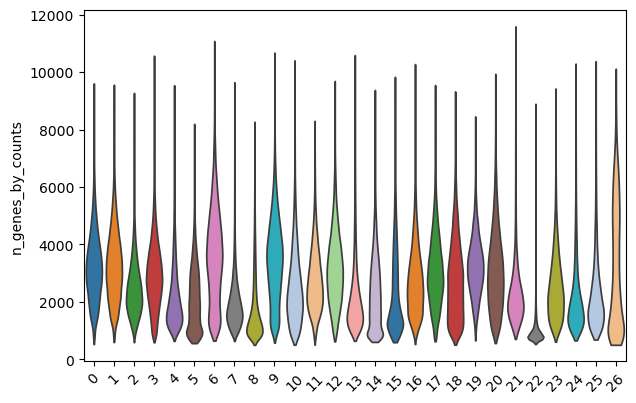

/home/liuxiaodongLab/jiangjing/miniconda3/envs/diffusionmap/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/liuxiaodongLab/jiangjing/miniconda3/envs/diffusionmap/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: UserWarning: 
The palette list has fewer values (15) than needed (27) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(


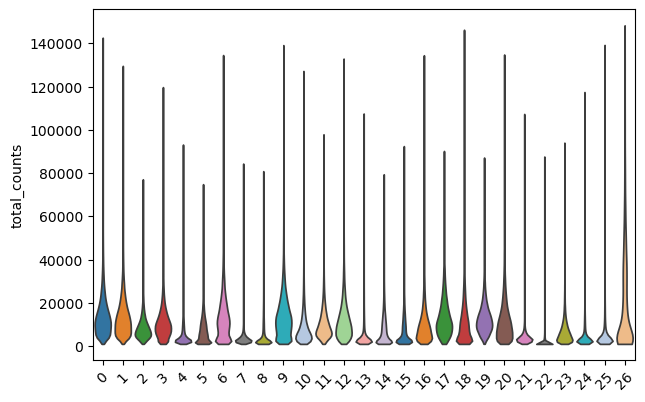

/home/liuxiaodongLab/jiangjing/miniconda3/envs/diffusionmap/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/liuxiaodongLab/jiangjing/miniconda3/envs/diffusionmap/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:900: UserWarning: 
The palette list has fewer values (15) than needed (27) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(


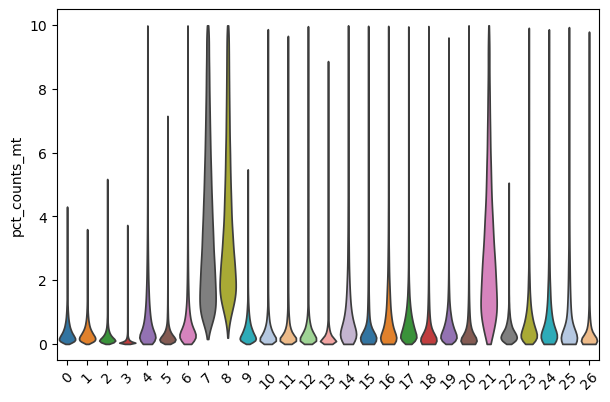

In [24]:
# 设置颜色方案
cluster_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5'
]

# 1. 检测到的基因数
sc.pl.violin(
    adata, 
    ['n_genes_by_counts'], 
    groupby='leiden',
    rotation=45,
    palette=cluster_colors,
    stripplot=False  # 不显示散点，图更清晰
)

# 2. 总UMI counts
sc.pl.violin(
    adata,
    ['total_counts'],
    groupby='leiden',
    rotation=45,
    palette=cluster_colors,
    stripplot=False
)

# 3. 线粒体基因百分比
sc.pl.violin(
    adata,
    ['pct_counts_mt'],
    groupby='leiden',
    rotation=45,
    palette=cluster_colors,
    stripplot=False
)



In [29]:
leiden_column = 'leiden'  # 根据实际情况修改

# 提取leiden=22的细胞
leiden_22_mask = adata.obs[leiden_column] == '22'
leiden_22_cells = adata[leiden_22_mask]
print(f"=== Leiden Cluster 22 详细质控统计 ===")
print(f"细胞数量: {leiden_22_cells.n_obs:,}")
print(f"占总细胞比例: {leiden_22_cells.n_obs/adata.n_obs*100:.2f}%")
print("-" * 50)

# 定义要查看的质控指标
qc_metrics = {
    'n_genes_by_counts': '检测基因数',
    'total_counts': '总UMI数', 
    'pct_counts_mt': '线粒体基因百分比(%)',
    'n_counts': '检测UMI数'
}

# 逐个指标计算统计
for metric, label in qc_metrics.items():
    if metric in leiden_22_cells.obs.columns:
        values = leiden_22_cells.obs[metric]
        
        print(f"\n{label}:")
        print(f"  最小值: {values.min():.2f}")
        print(f"  下四分位数(Q1): {values.quantile(0.25):.2f}")
        print(f"  中位数: {values.median():.2f}")
        print(f"  均值: {values.mean():.2f}")
        print(f"  上四分位数(Q3): {values.quantile(0.75):.2f}")
        print(f"  最大值: {values.max():.2f}")
        print(f"  标准差: {values.std():.2f}")
        print(f"  IQR范围: {values.quantile(0.25):.2f} - {values.quantile(0.75):.2f}")
        print(f"  通常范围(1.5×IQR): [{values.quantile(0.25)-1.5*(values.quantile(0.75)-values.quantile(0.25)):.2f}, {values.quantile(0.75)+1.5*(values.quantile(0.75)-values.quantile(0.25)):.2f}]")
    else:
        print(f"\n{label}: 该指标不存在于数据中")

=== Leiden Cluster 22 详细质控统计 ===
细胞数量: 20,456
占总细胞比例: 1.73%
--------------------------------------------------

检测基因数:
  最小值: 528.00
  下四分位数(Q1): 756.00
  中位数: 873.00
  均值: 994.64
  上四分位数(Q3): 1064.00
  最大值: 8897.00
  标准差: 424.51
  IQR范围: 756.00 - 1064.00
  通常范围(1.5×IQR): [294.00, 1526.00]

总UMI数:
  最小值: 954.00
  下四分位数(Q1): 1136.00
  中位数: 1346.00
  均值: 1754.41
  上四分位数(Q3): 1728.00
  最大值: 87632.00
  标准差: 1628.28
  IQR范围: 1136.00 - 1728.00
  通常范围(1.5×IQR): [248.00, 2616.00]

线粒体基因百分比(%):
  最小值: 0.00
  下四分位数(Q1): 0.18
  中位数: 0.31
  均值: 0.39
  上四分位数(Q3): 0.51
  最大值: 5.06
  标准差: 0.33
  IQR范围: 0.18 - 0.51
  通常范围(1.5×IQR): [-0.33, 1.02]

检测UMI数: 该指标不存在于数据中


In [6]:
import random
import numpy as np
from scipy import stats
import pandas as pd
from tqdm import tqdm

def find_highly_expressed_genes_sampling(adata, leiden_cluster='22', 
                                         leiden_col='leiden', 
                                         sample_size=10000,
                                         n_top_genes=100):
    """
    通过抽样快速找到高表达基因
    """
    
    print(f"🔍 分析 Leiden {leiden_cluster} 的高表达基因")
    print(f"使用抽样方法: {sample_size} 个对照细胞")
    
    # 获取细胞索引
    cluster_idx = adata.obs[leiden_col] == leiden_cluster
    other_idx = adata.obs[leiden_col] != leiden_cluster
    
    n_cluster_cells = sum(cluster_idx)
    n_other_cells = sum(other_idx)
    
    print(f"目标聚类细胞数: {n_cluster_cells:,}")
    print(f"其他细胞总数: {n_other_cells:,}")
    
    # 随机抽样对照细胞
    other_cell_indices = np.where(other_idx)[0]
    if len(other_cell_indices) > sample_size:
        sampled_indices = np.random.choice(other_cell_indices, 
                                          size=sample_size, 
                                          replace=False)
        sampled_other_idx = np.isin(np.arange(adata.n_obs), sampled_indices)
    else:
        sampled_other_idx = other_idx
    
    # 获取表达矩阵
    if scipy.sparse.issparse(adata.X):
        X_dense = adata.X.toarray()
    else:
        X_dense = adata.X
    
    print("\n📊 计算基因表达差异...")
    
    # 预计算每个基因的表达值
    results = []
    
    # 分批处理基因，避免内存溢出
    batch_size = 1000
    n_genes = adata.n_vars
    
    for start in tqdm(range(0, n_genes, batch_size)):
        end = min(start + batch_size, n_genes)
        
        for i in range(start, end):
            gene_name = adata.var_names[i]
            
            # 目标聚类的表达值
            expr_cluster = X_dense[cluster_idx, i]
            # 抽样对照的表达值
            expr_other = X_dense[sampled_other_idx, i]
            
            # 计算基本统计
            mean_cluster = np.mean(expr_cluster)
            mean_other = np.mean(expr_other)
            
            # 计算表达比例
            pct_cluster = np.mean(expr_cluster > 0) * 100
            pct_other = np.mean(expr_other > 0) * 100
            
            # 跳过在两组中都低表达的基因
            if mean_cluster < 0.1 and mean_other < 0.1:
                continue
            
            # 计算fold change（加伪计数避免除零）
            fold_change = (mean_cluster + 0.01) / (mean_other + 0.01)
            log2_fc = np.log2(fold_change)
            
            # Mann-Whitney U检验（比Wilcoxon快）
            if len(expr_cluster) > 1 and len(expr_other) > 1:
                try:
                    stat, pval = stats.mannwhitneyu(
                        expr_cluster, 
                        expr_other, 
                        alternative='greater'
                    )
                except:
                    pval = 1.0
            else:
                pval = 1.0
            
            results.append({
                'gene': gene_name,
                'mean_cluster': mean_cluster,
                'mean_other': mean_other,
                'log2_fc': log2_fc,
                'pct_cluster': pct_cluster,
                'pct_other': pct_other,
                'p_value': pval,
                'n_cluster': n_cluster_cells,
                'n_other': len(expr_other)
            })
    
    # 转换为DataFrame
    results_df = pd.DataFrame(results)
    
    # 多重检验校正
    from statsmodels.stats.multitest import multipletests
    reject, pvals_corrected, _, _ = multipletests(
        results_df['p_value'], 
        alpha=0.05, 
        method='fdr_bh'
    )
    results_df['p_adj'] = pvals_corrected
    
    # 筛选显著基因
    significant = results_df[
        (results_df['p_adj'] < 0.05) & 
        (results_df['log2_fc'] > 0) &  # log2FC > 1 (2倍)
        (results_df['pct_cluster'] > 20)  # 在>20%的细胞中表达
    ].sort_values('log2_fc', ascending=False)
    
    print(f"\n✅ 完成！找到 {len(significant)} 个显著高表达基因")
    
    return significant, results_df

# 运行分析
high_expr_genes, all_results = find_highly_expressed_genes_sampling(
    adata, 
    leiden_cluster='22',
    sample_size=5000  # 只抽样5000个对照细胞
)

print("\n🔝 前30个高表达基因:")
print(high_expr_genes.head(30).to_string())

🔍 分析 Leiden 22 的高表达基因
使用抽样方法: 5000 个对照细胞
目标聚类细胞数: 20,456
其他细胞总数: 1,164,040

📊 计算基因表达差异...


100%|██████████| 38/38 [05:03<00:00,  7.99s/it]



✅ 完成！找到 0 个显著高表达基因

🔝 前30个高表达基因:
Empty DataFrame
Columns: [gene, mean_cluster, mean_other, log2_fc, pct_cluster, pct_other, p_value, n_cluster, n_other, p_adj]
Index: []


In [12]:
all_results
significant = all_results[
    (all_results['p_adj'] < 0.05) & 
    (all_results['log2_fc'] > 0) 
].sort_values('log2_fc', ascending=False)
significant

In [13]:
significant

,gene,mean_cluster,mean_other,log2_fc,pct_cluster,pct_other,p_value,n_cluster,n_other,p_adj
2795,CSMD1,0.117430,0.040618,1.331976,5.631600,4.44,3.745751e-05,20456,5000,6.808395e-03
1799,H3Y1,0.443337,0.225297,0.946101,20.742081,17.70,4.601345e-18,20456,5000,1.444613e-15
4381,CCNA1,0.278494,0.148673,0.862487,13.502151,11.90,8.894002e-07,20456,5000,1.755168e-04
5109,MT1H,1.762856,1.139096,0.625577,70.580759,60.82,6.318847e-224,20456,5000,1.091107e-220
5108,MT1G,2.153517,1.406525,0.611023,80.548494,69.16,0.000000e+00,20456,5000,0.000000e+00
3163,KLF4,1.258987,0.881074,0.510060,54.213923,56.60,2.219446e-79,20456,5000,1.703302e-76
1662,GRID2,0.922657,0.668115,0.459817,40.877982,42.12,3.046217e-20,20456,5000,1.107380e-17
2184,POU5F1,2.816370,2.069948,0.442403,91.640594,84.36,0.000000e+00,20456,5000,0.000000e+00
3783,MALAT1,3.024200,2.299797,0.393550,94.896363,93.12,0.000000e+00,20456,5000,0.000000e+00
5110,MT1X,1.789807,1.387871,0.364612,71.050059,71.96,2.873985e-123,20456,5000,2.835802e-120


In [14]:
adata=sc.read_h5ad("/storage2/liuxiaodongLab/jiangjing/Projects/XueyingFan/PD_XueyingFan/20260209_hypoblast_99sample_anno/label_transfer/adata_qc_with_groups_scpoli_lineage.h5ad")

In [15]:
adata.obs['orig.ident']=adata.obs['batch']
#adata.obs['lineage_pred']=adata.obs['lineage_pred_pred']

In [16]:
adata_hvg = adata[:, adata.var.highly_variable].copy()


In [17]:
adata_hvg.write_h5ad("/storage2/liuxiaodongLab/jiangjing/Projects/XueyingFan/PD_XueyingFan/20260209_hypoblast_99sample_anno/output/adata_qc_with_groups_label_hvg.h5ad")